# Predict hotel bookings via user behaviour

## 1.) Let's load the data first and do a preliminary analysis

In [1]:
#Load libraries

import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

import gc
from IPython.display import Image

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


C:\Users\vivekanand.joshi\AppData\Local\Programs\Python\Python36\Lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


There are two data files. 

   **Booking (case_study_bookings_train)** : List of sessions, each with: session-related contextual data, and whether at least one booking was made.
   
   **User Actions (case_study_actions_train)** : Sequence of various type of user actions generated during the usage of the website.


In [2]:
#Let us load the data files.

train_data_booking = pd.read_csv("case_study_bookings_train.csv", sep=r'\t')
train_data_actions = pd.read_csv("case_study_actions_train.csv", sep=r'\t')

- **Columns:**


	- ymd: Date of the session in format 'yyMMdd'
	- user_id: Anonymized cookie id of the visitor
	- session_id: Anonymized id of the session
    - action_id: Type of the action
    - reference: Object of the action. - We note that action_ids with big set of reference values (e.g. action id '2116') are typically related to the content (e.g hotels, destinations or keywords); while action_ids with small reference set (e.g. action id '2351') are more related a function of the website (e.g. sorting order, room type, filters, etc.)
    - step: The number identifying the action in the session
	- referer_code: Encoded category of the referer to the website
	- is_app: If the session was made using the trivago app
	- agent_id: Encoded type of the browser
	- traffic_type: A categorization of the type of the traffic
	- has_booking: 1 if at least one booking was made during the session (excluded from the target set)

In [3]:
#Function to siplay full data instead of ellipses (...)
#This help in checking the data through maked eyes if you want to check more rows.

def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000): 
        display(df)

In [4]:
display_all(train_data_booking.head(10))

,ymd,user_id,session_id,referer_code,is_app,agent_id,traffic_type,has_booking
0,20170423,388309106223940,3052767322364990735,0,0,2,1,0
1,20170410,452426828488840,1022778951418899936,0,0,10,2,0
2,20170415,452426828488840,4191504489082712531,0,0,10,2,0
3,20170406,819438352219100,4560227804862289210,1,0,1,1,0
4,20170407,1113732603712480,4115013282086590434,0,0,9,2,0
5,20170419,1607565913119260,5462519157199531712,1,0,14,1,0
6,20170416,1799104857432640,6192546532479759064,99,0,1,6,0
7,20170417,2193000336357140,218841333828334811,99,0,1,6,0
8,20170416,2413031573758500,6317573206950631304,1,0,2,2,0
9,20170404,2427966799998760,1055322285624855013,99,0,7,6,0


In [5]:
display_all(train_data_actions.head(10))

,ymd,user_id,session_id,action_id,reference,step
0,20170423,388309106223940,3052767322364990735,8001,1323836,1
1,20170410,452426828488840,1022778951418899936,2116,929835,1
2,20170410,452426828488840,1022778951418899936,6999,0,2
3,20170410,452426828488840,1022778951418899936,2116,929835,3
4,20170410,452426828488840,1022778951418899936,2503,1,4
5,20170410,452426828488840,1022778951418899936,8001,929835,5
6,20170415,452426828488840,4191504489082712531,2113,447485,1
7,20170415,452426828488840,4191504489082712531,6999,0,2
8,20170415,452426828488840,4191504489082712531,2113,447485,3
9,20170406,819438352219100,4560227804862289210,2100,0,1


In [6]:
print(train_data_booking.shape, train_data_actions.shape)

(307677, 8) (5862863, 6)


Data has been loaded successfully

In [7]:
#Let's check for missing values.

def check_missing_data(df):
    total = df.isnull().sum().sort_values(ascending=False)
    percent = (df.isnull().sum()/df.isnull().count()*100).sort_values(ascending = False)
    missing_data =pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    return missing_data

In [8]:
check_missing_data(train_data_booking)

,Total,Percent
has_booking,0,0.0
traffic_type,0,0.0
agent_id,0,0.0
is_app,0,0.0
referer_code,0,0.0
session_id,0,0.0
user_id,0,0.0
ymd,0,0.0


In [9]:
check_missing_data(train_data_actions)

,Total,Percent
step,0,0.0
reference,0,0.0
action_id,0,0.0
session_id,0,0.0
user_id,0,0.0
ymd,0,0.0


### We have no missing values. Wow!! Is the problem this simple?

But if we look closely first 10 rows of train_data_booking, has_booking is always zero. This suggests us target value might be imbalanced. This is the catch.

Class 0: 288030
Class 1: 19647
Proportion: 14.66 : 1


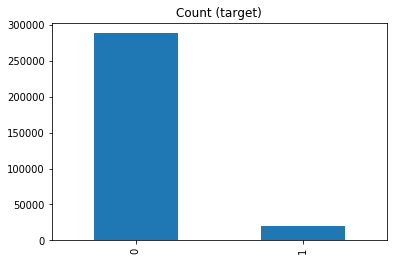

In [10]:
#So, let's quickly check the skewness of target variable. Is it highly skewed?

target_count = train_data_booking.has_booking.value_counts()
print('Class 0:', target_count[0])
print('Class 1:', target_count[1])
print('Proportion:', round(target_count[0] / target_count[1], 2), ': 1')

target_count.plot(kind='bar', title='Count (target)');

As suspected, it is highly skewed. Most of the rows corresponds to no-booking.

Before doing anything, let's merge two datasets. The dataset can be joined on **ymd**, **user_id** and **session_id**

In [11]:
train_data = pd.merge(train_data_actions, train_data_booking,  
                      how='left', left_on=['ymd','user_id', 'session_id'], right_on = ['ymd','user_id', 'session_id'])

In [12]:
display_all(train_data.head(10))

,ymd,user_id,session_id,action_id,reference,step,referer_code,is_app,agent_id,traffic_type,has_booking
0,20170423,388309106223940,3052767322364990735,8001,1323836,1,0,0,2,1,0
1,20170410,452426828488840,1022778951418899936,2116,929835,1,0,0,10,2,0
2,20170410,452426828488840,1022778951418899936,6999,0,2,0,0,10,2,0
3,20170410,452426828488840,1022778951418899936,2116,929835,3,0,0,10,2,0
4,20170410,452426828488840,1022778951418899936,2503,1,4,0,0,10,2,0
5,20170410,452426828488840,1022778951418899936,8001,929835,5,0,0,10,2,0
6,20170415,452426828488840,4191504489082712531,2113,447485,1,0,0,10,2,0
7,20170415,452426828488840,4191504489082712531,6999,0,2,0,0,10,2,0
8,20170415,452426828488840,4191504489082712531,2113,447485,3,0,0,10,2,0
9,20170406,819438352219100,4560227804862289210,2100,0,1,1,0,1,1,0


In [13]:
train_data.shape

(5862863, 11)

One of the issues that we can fell into when working with imbalanced data sets is to use wrong metric to evaluate the model. Using simpler metrics like **accuracy_score** can lead to high accuracy even if classifier predicts everything as in most common class. We have high accuracy but only as an illusion.

In [22]:
# Remove 'id' and 'target' columns
labels = train_data.columns[:10]

X = train_data[labels]
y = train_data['has_booking']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(4690290, 10) (1172573, 10) (4690290,) (1172573,)


In [19]:
model = XGBClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

[00:51:28] Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.


C:\Users\vivekanand.joshi\AppData\Local\Programs\Python\Python36\Lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Accuracy: 87.09%


Let us train the model only using one feature. This should reduce the accuracy drastically, right?

In [20]:
model = XGBClassifier()
model.fit(X_train[['action_id']], y_train)
y_pred = model.predict(X_test[['action_id']])

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

[01:13:41] Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
Accuracy: 87.04%


C:\Users\vivekanand.joshi\AppData\Local\Programs\Python\Python36\Lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


We noticed that accuracy is still the same. This means this is not the correct metric to score.

## Confusion Matrix

An interesting way to evaluate the results is by the means of confusion matrix, which shows the correct and incorrect predictions for each class. In the first row, the first column indicates how many classes 0 were predicted correctly, and the second column, how many classes 0 were predicted as 1. In the second row, we note that all class 1 entries were erroneously predicted as class 0.

Therefore, the higher the diagonal values of the confusion matrix the better, indicating many correct predictions.

Confusion matrix:
 [[1020556       0]
 [ 152017       0]]


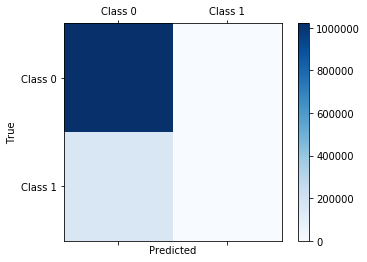

In [23]:
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt

conf_mat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print('Confusion matrix:\n', conf_mat)

labels = ['Class 0', 'Class 1']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

We can use a technique called sampling. 

It consists of removing samples from the majority class (under-sampling) and / or adding more examples from the minority class (over-sampling).

   ![alt text](resampling.png "Title")

## Random Under-Sampling

In [28]:
# Class count
count_class_0, count_class_1 = train_data.has_booking.value_counts()

# Divide by class
df_class_0 = train_data[train_data['has_booking'] == 0]
df_class_1 = train_data[train_data['has_booking'] == 1]

Random under-sampling:
1    762309
0    762309
Name: has_booking, dtype: int64


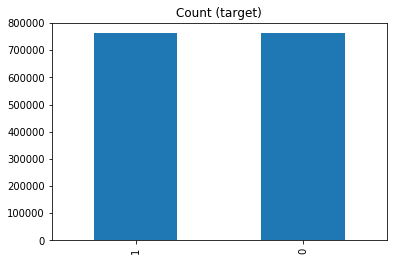

In [29]:
df_class_0_under = df_class_0.sample(count_class_1)
df_test_under = pd.concat([df_class_0_under, df_class_1], axis=0)

print('Random under-sampling:')
print(df_test_under.has_booking.value_counts())

df_test_under.has_booking.value_counts().plot(kind='bar', title='Count (target)');

## Random Over-Sampling

Random over-sampling:
1    5100554
0    5100554
Name: has_booking, dtype: int64


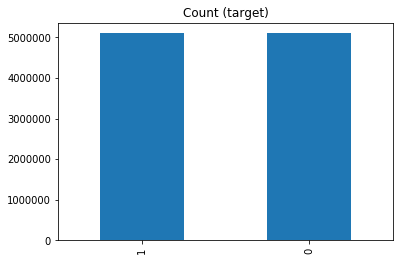

In [30]:
df_class_1_over = df_class_1.sample(count_class_0, replace=True)
df_test_over = pd.concat([df_class_0, df_class_1_over], axis=0)

print('Random over-sampling:')
print(df_test_over.has_booking.value_counts())

df_test_over.has_booking.value_counts().plot(kind='bar', title='Count (target)');

In [32]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(return_indices=True)
X_rus, y_rus, id_rus = rus.fit_sample(X, y)

print('Removed indexes:', id_rus)

plot_2d_space(X_rus, y_rus, 'Random under-sampling')

In [35]:
from sklearn.datasets import 

ImportError: cannot import name '_Mapping'

In [ ]:
# distincts_per_user = train_data.groupby("user_id", as_index=False).agg({"ymd": lambda x: x.nunique(),
#                                                                                 "session_id": lambda x: x.nunique(),
#                                                                                 "action_id": lambda x: x.nunique(),
#                                                                                 "reference": lambda x: x.nunique(),
#                                                                                 "is_app": lambda x: x.nunique(),
#                                                                                 "agent_id": lambda x: x.nunique(),
#                                                                                 "traffic_type": lambda x: x.nunique(),
#                                                                                 "has_booking": lambda x: x.nunique()
#                                                                                })
# display_all(distincts_per_user.head(10))
# display_all(distincts_per_user.shape)

distincts_per_user.columns = ['user_id', 'number_of_distinct_dates', 'number_of_distinct_sessions',
                              'number_of_distinct_actions', 'number_of_distinct_refrences']
#display_all(distincts_per_user.head())

In [ ]:
display_all(distincts_per_user[(distincts_per_user.is_app > 1) |
                       (distincts_per_user.agent_id > 1) | 
                       (distincts_per_user.traffic_type > 1 | 
                        (distincts_per_user.has_booking > 1))].head(10))

In [ ]:
display_all(train_data.action_id.value_counts())

In [ ]:
train_data.shape

In [ ]:
def check_missing_data(df):
    total = df.isnull().sum().sort_values(ascending=False)
    percent = (df.isnull().sum()/df.isnull().count()*100).sort_values(ascending = False)
    missing_data =pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    return missing_data

check_missing_data(train_data)

In [ ]:
train_data.info()

In [ ]:
del train_data_actions, train_data_booking

In [ ]:
gc.collect()

In [ ]:
test_data_booking = pd.read_csv("case_study_bookings_target.csv", sep=r'\t')
test_data_action = pd.read_csv("case_study_actions_target.csv", sep=r'\t')

test_data = pd.merge(test_data_action, test_data_booking,  
                      how='left', left_on=['ymd','user_id', 'session_id'], right_on = ['ymd','user_id', 'session_id'])

In [ ]:
test_data.shape

In [ ]:
def check_missing_data(df):
    total = df.isnull().sum().sort_values(ascending=False)
    percent = (df.isnull().sum()/df.isnull().count()*100).sort_values(ascending = False)
    missing_data =pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    return missing_data

check_missing_data(test_data)

train_data = number_of_sessions_per_user

train_data = pd.merge(train_data, number_of_sessions_per_user,  
                      how='left', left_on=['user_id'], right_on = ['user_id'])

display_all(train_data.head(1000))

In [ ]:
sns.countplot(x='is_app', hue='has_booking',data=train_data)
plt.figure(figsize=(40,20))
plt.show()

In [ ]:
sns.countplot(x='agent_id', hue='has_booking',data=train_data)
plt.figure(figsize=(40,20))
plt.show()

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
rf.fit(train_data.drop('has_booking', axis = 1), train_data.has_booking)

rf.score(train_data.drop('has_booking', axis = 1), train_data.has_booking)

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(train_data.drop('has_booking', axis =1), train_data.has_booking,
                                                    train_size=0.8, random_state=42)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

In [ ]:
rf = RandomForestClassifier()
%time rf.fit(X_train, y_train)

%time rf.score(X_test, y_test)

In [ ]:
train_pred = rf.predict(X_train)
train_true = y_train

from sklearn.metrics import matthews_corrcoef

%time print(matthews_corrcoef(train_pred, train_true))



valid_pred = rf.predict(X_test)
valid_true = y_test

from sklearn.metrics import matthews_corrcoef

%time print(matthews_corrcoef(valid_pred, valid_true))

In [ ]:
train_data['has_booking'].value_counts().plot.bar()
plt.title('HasBookings(target)')